In [2]:
from utils import *
%matplotlib inline

In [4]:
train_data = pd.read_csv("../Data/Combined data/train_data/train_data.csv", index_col=0) 
val_data = pd.read_csv("../Data/Combined data/validation_data.csv", index_col=0)
test_data = pd.read_csv("../Data/Combined data/test_data.csv", index_col=0)

# Feature creation

In [55]:
# Creating functions to get various features

def get_pos_tags(text): # POS tags reference: https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/ 
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags

def get_num_nouns(text):
    nouns_list = ['NN', 'NNS', 'NNP', 'NNPS']
    pos_tags = get_pos_tags(text)
    nouns_count = len([word for (word, pos) in pos_tags if pos in nouns_list])
    return nouns_count

def get_num_verbs(text):
    verbs_list = ['VB', 'VBD', 'VBG', 'VBN', 'VDP', 'VBZ']
    pos_tags = get_pos_tags(text)
    verbs_count = len([word for (word, pos) in pos_tags if pos in verbs_list])
    return verbs_count

def get_num_adj(text):
    adj_list = ['JJ', 'JJR', 'JJS']
    pos_tags = get_pos_tags(text)
    adj_count = len([word for (word, pos) in pos_tags if pos in adj_list])
    return adj_count

def get_num_discourse(text):
    discourse_keywords = ['even then', 'as though', 'still', 'whereas', 'on the other hand', 'but', 'while', 'ultimately', 'if', 'even when', 'instead', 'next', 'when', 'on the one hand indeed', 'even still', 'in the end', 'meanwhile', 'separately', 'or', 'nonetheless', 'neither', 'in contrast', 'nevertheless', 'although', 'then', 'in turn', 'regardless', 'as much as', 'rather', 'meantime', 'much as', 'yet', 'however', 'even as', 'conversely', 'even after', 'nor', 'finally', 'as if', 'in fact', 'also', 'even if', 'by comparison', 'and', 'besides', 'by contrast', 'on the contrary', 'even though', 'though']
    tokens = nltk.word_tokenize(text)
    discourse_count = len([word for word in tokens if word in discourse_keywords])
    return discourse_count

def get_num_stopwords(text):
    tokens = nltk.word_tokenize(text)
    stopword_count = len([word for word in tokens if word in stopwords.words('english')])
    return stopword_count

def get_num_punctuations(text):
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    punctuation_count = len([char for char in text if char in punctuations])
    return punctuation_count

def get_num_words_in_quotes(text):
    quotes = re.findall("'.'|\".\"", text)
    quote_count = 0
    if quotes is None:
        return 0
    else:
        for quote in quotes:
            words_in_quote = quote[1:-1]
            quote_count += len(words_in_quote.split())
        return quote_count

In [5]:
def create_features(dataframe):
    """
        Adds 13 additional features to an input dataframe and returns the updated dataframe
    """
    num_nouns = []
    num_verbs = []
    num_adj = []
    num_discourse = []
    num_stopwords = []
    num_punctuations = []
    num_quote_words = []

    for row in dataframe['text']:
        nouns_count = get_num_nouns(row)
        num_nouns.append(nouns_count)

        verbs_count = get_num_verbs(row)
        num_verbs.append(verbs_count)
        
        adj_count = get_num_adj(row)
        num_adj.append(adj_count)
        
        discourse_count = get_num_discourse(row)
        num_discourse.append(discourse_count)

        stopword_count = get_num_stopwords(row)
        num_stopwords.append(stopword_count)

        punctuation_count = get_num_punctuations(row)
        num_punctuations.append(punctuation_count)

        quote_count = get_num_words_in_quotes(row)
        num_quote_words.append(quote_count)
    
    dataframe['char_count'] = dataframe['text'].apply(lambda x: len(str(x)))
    dataframe['word_count'] = dataframe['text'].apply(lambda x: len(str(x).split(" ")))
    dataframe['sentence_count'] = dataframe['text'].apply(lambda x: len(str(x).split(".")))
    dataframe["num_unique_words"] = dataframe['text'].apply(lambda x: len(set(str(x).split(" "))))
    dataframe["avg_sentence_length"] = dataframe['word_count']/dataframe['sentence_count']
    dataframe['num_punctuations'] = num_punctuations
    dataframe['num_stopwords'] = num_stopwords
    dataframe['num_words_in_quotes'] = num_quote_words
    dataframe['num_nouns'] = num_nouns
    dataframe['num_verbs'] = num_verbs
    dataframe['num_adjectives'] = num_adj
    dataframe['num_discourse_relations'] = num_discourse
    dataframe['textblob_sentiment'] = dataframe['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    return dataframe

In [49]:
# Running create_features and output a new csv

train_data_added_features_raw = create_features(train_data)
val_data_added_features_raw = create_features(val_data)
test_data_added_features_raw = create_features(test_data)

train_data_added_features_raw.to_csv("../Data/Data with added features/Raw counts/train_data_added_features_raw.csv")
val_data_added_features_raw.to_csv("../Data/Data with added features/Raw counts/val_data_added_features_raw.csv")
test_data_added_features_raw.to_csv("../Data/Data with added features/Raw counts/test_data_added_features_raw.csv")

In [81]:
# # Run only if working on the following sections without running previous sections
# train_data_added_features_raw = pd.read_csv("../Data/Data with added features/Raw counts/train_data_added_features_raw.csv", index_col=0)
# val_data_added_features_raw = pd.read_csv("../Data/Data with added features/Raw counts/val_data_added_features_raw.csv", index_col=0)
# test_data_added_features_raw = pd.read_csv("../Data/Data with added features/Raw counts/test_data_added_features_raw.csv", index_col=0)

In [84]:
def calculate_proportion(new_dataframe, dataframe):
    '''
    Calculate proportion for some features as different articles have different lengths. Longer articles will tend to have higher absolute numbers for counts. Returns a new dataframe
    '''
    new_dataframe['text'] = dataframe['text']
    new_dataframe['class_label'] = dataframe['class_label']
    new_dataframe['text_preprocessed'] = dataframe['text_preprocessed']
    new_dataframe['char_count'] = dataframe['char_count']
    new_dataframe['word_count'] = dataframe['word_count']
    new_dataframe['sentence_count'] = dataframe['sentence_count']
    new_dataframe["prop_unique_words"] = dataframe["num_unique_words"]/dataframe['word_count']
    new_dataframe["avg_sentence_length"] = dataframe["avg_sentence_length"]
    new_dataframe['prop_punctuations'] = dataframe['num_punctuations']/dataframe['char_count']
    new_dataframe['prop_stopwords'] = dataframe['num_stopwords']/dataframe['word_count']
    new_dataframe['prop_words_in_quotes'] = dataframe['num_words_in_quotes']/dataframe['word_count']
    new_dataframe['prop_nouns'] = dataframe['num_nouns']/dataframe['word_count']
    new_dataframe['prop_verbs'] = dataframe['num_verbs']/dataframe['word_count']
    new_dataframe['prop_adjectives'] = dataframe['num_adjectives']/dataframe['word_count']
    new_dataframe['prop_discourse_relations'] = dataframe['num_discourse_relations']/dataframe['word_count']
    new_dataframe['textblob_sentiment'] = dataframe['textblob_sentiment']

    return new_dataframe

In [85]:
train_data_added_features_prop = pd.DataFrame()
train_data_added_features_prop = calculate_proportion(train_data_added_features_prop, train_data_added_features_raw)

val_data_added_features_prop = pd.DataFrame()
val_data_added_features_prop = calculate_proportion(val_data_added_features_prop, val_data_added_features_raw)

test_data_added_features_prop = pd.DataFrame()
test_data_added_features_prop = calculate_proportion(test_data_added_features_prop, test_data_added_features_raw)

train_data_added_features_prop.to_csv("../Data/Data with added features/Proportion/train_data_added_features.csv")
val_data_added_features_prop.to_csv("../Data/Data with added features/Proportion/val_data_added_features.csv")
test_data_added_features_prop.to_csv("../Data/Data with added features/Proportion/test_data_added_features.csv")

# Visualising added features

In [7]:
# Run only if working on the following sections without running previous sections
train_data_added_features = pd.read_csv("../Data/Data with added features/Proportion/train_data_added_features.csv", index_col=0)
val_data_added_features = pd.read_csv("../Data/Data with added features/Proportion/val_data_added_features.csv", index_col=0)
test_data_added_features = pd.read_csv("../Data/Data with added features/Proportion/test_data_added_features.csv", index_col=0)

In [ ]:
train_data_added_features = train_data_added_features_prop
val_data_added_features = val_data_added_features_prop
test_data_added_features = test_data_added_features_prop

## Data Transformation

In [5]:
def transform(df):
    '''
    Returns a new dataframe with skewed columns transformed(log base 10). No changes to columns that are not skewed.
    '''
    columns = df.columns
    skewed_columns = []

    print(f'-------- skewed columns --------')
    for column in columns[3:]:
        if df[column].skew() > 1 or df[column].skew() < -1:
            skewed_columns.append(column)
            print(column, round(df[column].skew(), 5))

    for col in df:
        if col in skewed_columns:
            df[col] = np.where(df[col]>0, np.log10(df[col]), 0)
        else:
            df[col] = df[col]
    return df

np.seterr(divide = 'ignore') # Turns off warnings

train_data_added_features_transformed = transform(train_data_added_features)
val_data_added_features_transformed = transform(val_data_added_features)
test_data_added_features_transformed = transform(test_data_added_features)

-------- skewed columns --------
char_count 7.7773
word_count 8.17545
sentence_count 8.6406
avg_sentence_length 7.1413
prop_punctuations 5.20096
prop_stopwords -2.50171
prop_words_in_quotes 182.30718
prop_nouns 3.58647
prop_verbs -1.24762
prop_adjectives 7.49351
-------- skewed columns --------
char_count 10.74569
word_count 10.03406
sentence_count 12.74551
avg_sentence_length 5.99187
prop_punctuations 5.26465
prop_stopwords -2.48305
prop_words_in_quotes 76.25916
prop_nouns 3.38476
prop_verbs -1.22142
prop_adjectives 9.48372
-------- skewed columns --------
char_count 7.63037
word_count 7.79886
sentence_count 7.69115
avg_sentence_length 5.99289
prop_punctuations 5.84049
prop_stopwords -2.44042
prop_words_in_quotes 71.23635
prop_nouns 3.99628
prop_verbs -1.22922


array([[<AxesSubplot:title={'center':'class_label'}>,
        <AxesSubplot:title={'center':'char_count'}>,
        <AxesSubplot:title={'center':'word_count'}>,
        <AxesSubplot:title={'center':'sentence_count'}>],
       [<AxesSubplot:title={'center':'prop_unique_words'}>,
        <AxesSubplot:title={'center':'avg_sentence_length'}>,
        <AxesSubplot:title={'center':'prop_punctuations'}>,
        <AxesSubplot:title={'center':'prop_stopwords'}>],
       [<AxesSubplot:title={'center':'prop_words_in_quotes'}>,
        <AxesSubplot:title={'center':'prop_nouns'}>,
        <AxesSubplot:title={'center':'prop_verbs'}>,
        <AxesSubplot:title={'center':'prop_adjectives'}>],
       [<AxesSubplot:title={'center':'prop_discourse_relations'}>,
        <AxesSubplot:title={'center':'textblob_sentiment'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

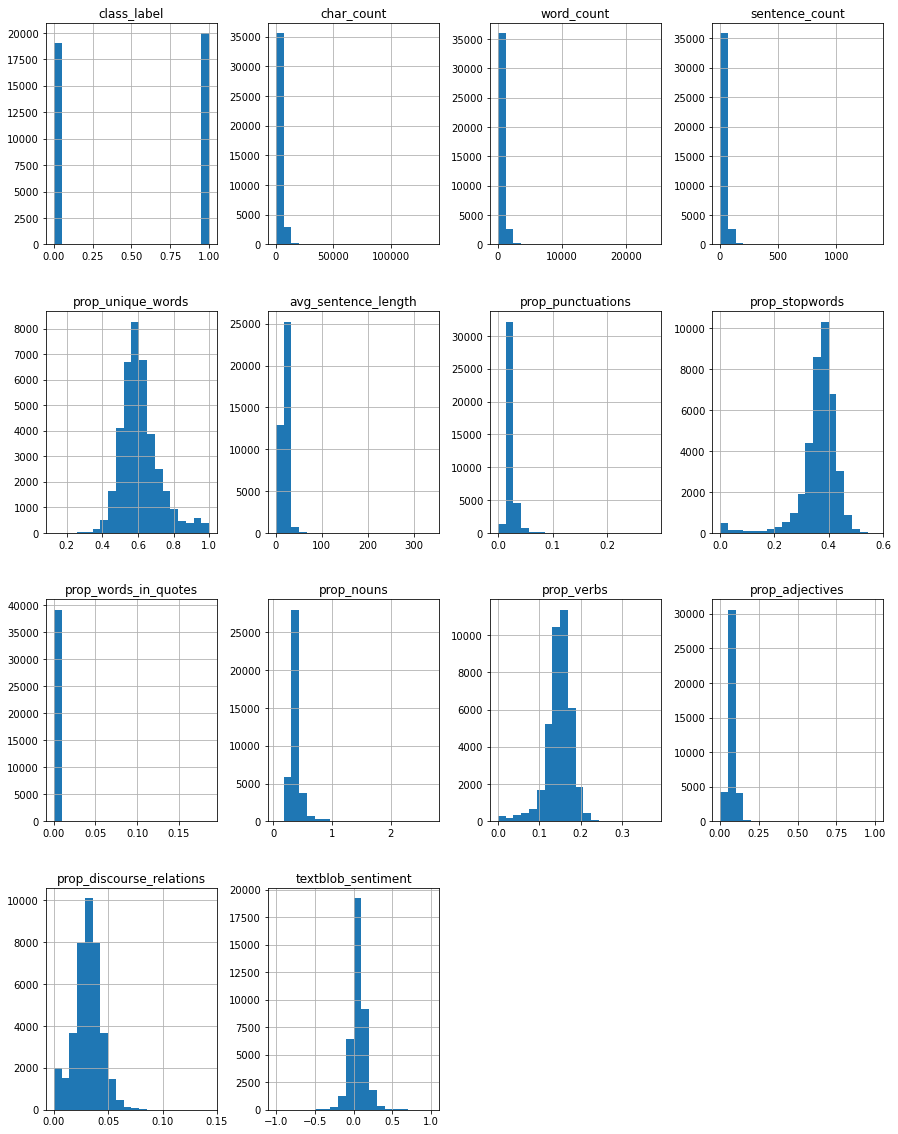

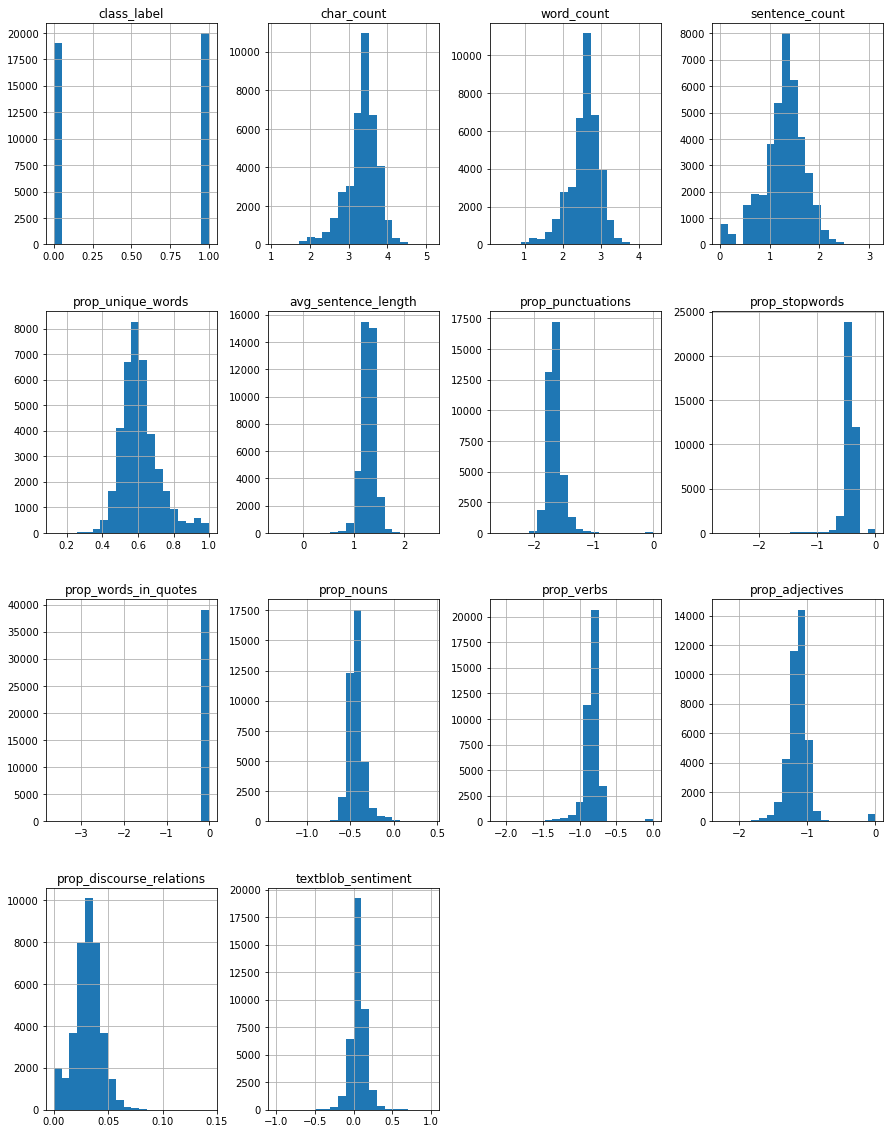

In [8]:
def plot_histograms(df):   
    columns = df.columns
    return df[columns].hist(bins=20, figsize=(15,20), layout=(4,4))

plot_histograms(train_data_added_features)
plot_histograms(train_data_added_features_transformed)

## Scaling

In [25]:
def scale(new_dataframe, dataframe):
    '''
    Returns a new dataframe with numeric columns scaled using MinMaxScaler
    '''
    scaler = MinMaxScaler()
    new_dataframe['text'] = dataframe['text']
    new_dataframe['class_label'] = dataframe['class_label']
    new_dataframe['text_preprocessed'] = dataframe['text_preprocessed']
    
    df = pd.DataFrame(scaler.fit_transform(dataframe.iloc[:, 3:]), columns = dataframe.columns[3:])

    new_dataframe = pd.concat([df, new_dataframe])
    return new_dataframe

np.seterr(divide = 'ignore') # Turns off warnings

train_data_added_features_scaled = pd.DataFrame()
train_data_added_features_scaled = scale(train_data_added_features_scaled, train_data_added_features_transformed)

val_data_added_features_scaled = pd.DataFrame()
val_data_added_features_scaled = scale(val_data_added_features_scaled, val_data_added_features_transformed)

test_data_added_features_scaled = pd.DataFrame()
test_data_added_features_scaled = scale(test_data_added_features_scaled, test_data_added_features_transformed)

In [27]:
def plot_boxplots(df):
    columns = df.columns[3:]
    plt.figure(figsize=(28, 25))

    for i in range(1, len(columns)):
        plt.subplot(4, 4, i + 1)
        sns.boxplot(x='class_label', y=columns[i], data=df)
        plt.xlabel('class_label', fontsize=18)
        plt.ylabel(columns[i], fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
    plt.show()

# Testing base model performance with/without added features using TFIDF

### Creating X_train_added_features and X_test_added_features

In [ ]:
# Initialise TfidfVectorizer with min_df = 0.01 as per feature selection
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,2), min_df=0.01)

# Create mapper object to combine added features and tfidf word vectors
mapper = DataFrameMapper([
    (['char_count', 'word_count', 'sentence_count', 'num_unique_words', 'avg_sentence_length', 'num_punctuations', 'num_stopwords', 'num_words_in_quotes', 'num_nouns', 'num_verbs', 'num_adjectives', 'num_discourse_relations', 'textblob_sentiment'], None), 
    ('text_preprocessed', tfidf_vectorizer)
])

# fit_transform mapper on train data with added features and transform test data with added features
X_train_added_features = mapper.fit_transform(train_data_added_features)
X_test_added_features = mapper.transform(test_data_added_features)
print(X_train_added_features.shape)
print(X_test_added_features.shape)

### Creating X_train, X_test and y_train, y_test

In [ ]:
X_train = tfidf_vectorizer.fit_transform(train_data["text_preprocessed"].values)
X_test = tfidf_vectorizer.transform(test_data["text_preprocessed"].values)

y_train = train_data["class_label"].values
y_test = test_data["class_label"].values

## Testing base model - Default

In [58]:
# define base model
naive_bayes_clf = BernoulliNB()

In [ ]:
naive_bayes_clf.fit(X_train, y_train)
y_pred = naive_bayes_clf.predict(X_test)
print(classification_report(y_test, y_pred))

## Testing base model - Added Features

In [ ]:
naive_bayes_clf.fit(X_train_added_features, y_train)
y_pred = naive_bayes_clf.predict(X_test_added_features)
print(classification_report(y_test, y_pred))

## Testing base model - Added Features (Scaled)

In [ ]:
# Scale X
X_train_added_features_scaled = MinMaxScaler().fit_transform(X_train_added_features)
X_test_added_features_scaled = MinMaxScaler().fit_transform(X_test_added_features)

In [ ]:
naive_bayes_clf.fit(X_train_added_features_scaled, y_train)
y_pred = naive_bayes_clf.predict(X_test_added_features_scaled)
print(classification_report(y_test, y_pred))